# TD-MPC2 Results & W&B Evaluation Diagnostics

Purpose:
1. Load local baseline CSV reward curves.
2. Fetch all W&B runs for project.
3. Extract every evaluation point (step, eval/episode_reward) without sampling loss.
4. Print for EACH run:
   - Config eval_freq, steps if present.
   - Count of eval points vs theoretical expectation.
   - First 10 and last 10 (step,reward) pairs.
   - Full list (raw) optionally truncated only in display logic.
5. Identify causes for missing points (e.g., episode-alignment vs. API sampling) with heuristic flags.

Sections:
- Section 1: Baseline CSV ingestion & summary (unchanged logic, slightly streamlined).
- Section 2: W&B evaluation extraction & diagnostics (rewritten).

In [37]:
# 0. Shared Imports & Helper Functions (added)
import os, math, time, json, warnings, re
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid', context='notebook')
plt.rcParams['figure.figsize'] = (8,4)
print('Base libraries imported.')

def expected_eval_count(steps:int, freq:int):
    if freq <= 0:
        return None
    # includes step 0 and final if divisible: floor(steps/freq)+1
    return steps//freq + 1


Base libraries imported.


In [38]:
# 2. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json, re, warnings
try:
    import ipywidgets as widgets
except ImportError:
    widgets = None

sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (8,4)
print("Libraries imported.")

Libraries imported.


In [39]:
# 3. Define Paths and Configuration (updated)
# We are executing this notebook from the repository root or from within the notebooks folder.
# Results live at: <repo_root>/results/tdmpc2-pixels (NOT inside notebooks)
from pathlib import Path

# Detect repo root by climbing until 'results' exists (max 3 levels)
_here = Path.cwd().resolve()
for _ in range(3):
    if (_here / 'results' / 'tdmpc2-pixels').is_dir():
        REPO_ROOT = _here
        break
    _here = _here.parent
else:
    raise RuntimeError("Could not locate results/tdmpc2-pixels directory relative to this notebook.")

RESULTS_DIR = REPO_ROOT / 'results' / 'tdmpc2-pixels'
NOTEBOOKS_DIR = REPO_ROOT / 'notebooks'
FIGURES_DIR = NOTEBOOKS_DIR / 'figures'
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print(f"Repo root: {REPO_ROOT}")
print(f"Results dir: {RESULTS_DIR}")
print(f"Figures dir: {FIGURES_DIR}")

FILE_PATTERN = '*.csv'
REQUIRED_COLUMNS = {'step','reward','seed'}

Repo root: C:\Users\thoma\OneDrive - Delft University of Technology\Documenten\Projects\Auxilary Signals World Models\tdmpc2
Results dir: C:\Users\thoma\OneDrive - Delft University of Technology\Documenten\Projects\Auxilary Signals World Models\tdmpc2\results\tdmpc2-pixels
Figures dir: C:\Users\thoma\OneDrive - Delft University of Technology\Documenten\Projects\Auxilary Signals World Models\tdmpc2\notebooks\figures


In [40]:
# 4. Load Results Files

def load_task_csvs(results_dir: Path, pattern: str = FILE_PATTERN) -> pd.DataFrame:
    frames = []
    for path in sorted(results_dir.glob(pattern)):
        if not path.is_file():
            continue
        try:
            df = pd.read_csv(path)
        except Exception as e:
            warnings.warn(f"Failed to read {path.name}: {e}")
            continue
        df['__source_file'] = path.name
        frames.append(df)
    if not frames:
        raise FileNotFoundError(f"No result files matched pattern {pattern} in {results_dir}")
    data = pd.concat(frames, ignore_index=True)
    return data

raw_df = load_task_csvs(RESULTS_DIR)
print(f"Loaded rows: {len(raw_df)} from {raw_df['__source_file'].nunique()} files")
raw_df.head()

Loaded rows: 756 from 12 files


,step,reward,seed,__source_file
0,0,5.4,2,acrobot-swingup.csv
1,100000,8.0,2,acrobot-swingup.csv
2,200000,45.4,2,acrobot-swingup.csv
3,300000,48.2,2,acrobot-swingup.csv
4,400000,76.9,2,acrobot-swingup.csv


In [41]:
# 5. Inspect Raw Data Structure
print(raw_df.info())
print("Columns:", list(raw_df.columns))
print("Sample:")
raw_df.sample(min(5, len(raw_df)))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   step           756 non-null    int64  
 1   reward         756 non-null    float64
 2   seed           756 non-null    int64  
 3   __source_file  756 non-null    object 
dtypes: float64(1), int64(2), object(1)
memory usage: 23.8+ KB
None
Columns: ['step', 'reward', 'seed', '__source_file']
Sample:


,step,reward,seed,__source_file
51,900000,187.3,1,acrobot-swingup.csv
465,300000,53.5,2,quadruped-walk.csv
602,1400000,978.5,1,reacher-hard.csv
181,1300000,608.1,1,cheetah-run.csv
2,200000,45.4,2,acrobot-swingup.csv


In [42]:
# 6. Clean and Normalize Data
clean_df = raw_df.copy()
# Standardize column names
clean_df.columns = [c.strip().lower().replace(' ', '_') for c in clean_df.columns]
missing_cols = REQUIRED_COLUMNS - set(clean_df.columns)
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")
# Coerce types
for col in ['step','reward','seed']:
    clean_df[col] = pd.to_numeric(clean_df[col], errors='coerce')
# Drop NaNs
before = len(clean_df)
clean_df = clean_df.dropna(subset=['step','reward','seed'])
print(f"Dropped {before - len(clean_df)} rows with NaNs")
# Remove negative or nonsensical steps
clean_df = clean_df[clean_df['step'] >= 0]
clean_df.reset_index(drop=True, inplace=True)
clean_df.head()

Dropped 0 rows with NaNs


,step,reward,seed,__source_file
0,0,5.4,2,acrobot-swingup.csv
1,100000,8.0,2,acrobot-swingup.csv
2,200000,45.4,2,acrobot-swingup.csv
3,300000,48.2,2,acrobot-swingup.csv
4,400000,76.9,2,acrobot-swingup.csv


In [43]:
# 7. Extract Task Names and Metrics
# Derive task from source filename (remove extension)
clean_df['task'] = clean_df['__source_file'].str.replace('.csv','', regex=False)
# Metrics: reward over steps
metrics_long = clean_df[['task','step','reward','seed']].copy()
metrics_long.head()

,task,step,reward,seed
0,acrobot-swingup,0,5.4,2
1,acrobot-swingup,100000,8.0,2
2,acrobot-swingup,200000,45.4,2
3,acrobot-swingup,300000,48.2,2
4,acrobot-swingup,400000,76.9,2


In [44]:
# 8. Compute Per-Task Statistics (per step aggregation)
step_stats = (metrics_long
             .groupby(['task','step'])
             .agg(mean_reward=('reward','mean'),
                  std_reward=('reward','std'),
                  n=('reward','count'))
             .reset_index())
print(step_stats.head())

              task    step  mean_reward  std_reward  n
0  acrobot-swingup       0     4.800000    2.749545  3
1  acrobot-swingup  100000    13.133333    5.783886  3
2  acrobot-swingup  200000    23.233333   19.316918  3
3  acrobot-swingup  300000    52.433333   23.142241  3
4  acrobot-swingup  400000    98.633333   45.295622  3


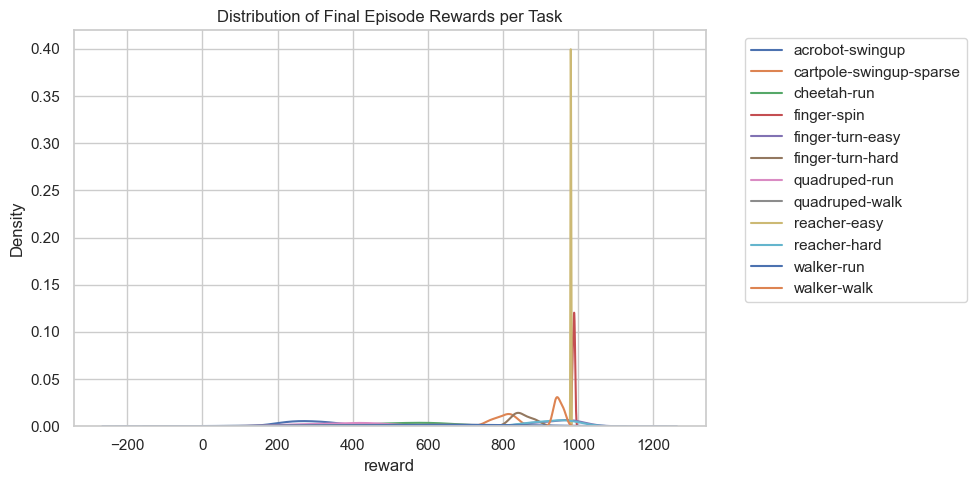

In [45]:
# 9. Plot Per-Task Reward Distributions (final step values)
final_step = metrics_long.sort_values('step').groupby(['task','seed']).tail(1)
plt.figure(figsize=(10,5))
for task in sorted(final_step['task'].unique()):
    sns.kdeplot(data=final_step[final_step.task==task], x='reward', label=task, fill=False)
plt.title('Distribution of Final Episode Rewards per Task')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

In [46]:
# 10. Plot Per-Task Mean Reward Curves with Std Shading
for task, grp in step_stats.groupby('task'):
    plt.figure()
    plt.plot(grp['step'], grp['mean_reward'], label=f'{task} mean')
    if grp['std_reward'].notna().any():
        upper = grp['mean_reward'] + grp['std_reward'].fillna(0)
        lower = grp['mean_reward'] - grp['std_reward'].fillna(0)
        plt.fill_between(grp['step'], lower, upper, alpha=0.25, label='±1 std')
    plt.title(f'Reward vs Step: {task}')
    plt.xlabel('Step')
    plt.ylabel('Episode Reward')
    plt.legend()
    out_file = FIGURES_DIR / f'{task}_reward_curve.png'
    plt.tight_layout()
    plt.savefig(out_file, dpi=120, bbox_inches='tight')
    plt.close()  # Close figure to avoid display
    plt.show()
    print(f'Saved {out_file}')

Saved C:\Users\thoma\OneDrive - Delft University of Technology\Documenten\Projects\Auxilary Signals World Models\tdmpc2\notebooks\figures\acrobot-swingup_reward_curve.png
Saved C:\Users\thoma\OneDrive - Delft University of Technology\Documenten\Projects\Auxilary Signals World Models\tdmpc2\notebooks\figures\cartpole-swingup-sparse_reward_curve.png
Saved C:\Users\thoma\OneDrive - Delft University of Technology\Documenten\Projects\Auxilary Signals World Models\tdmpc2\notebooks\figures\cheetah-run_reward_curve.png
Saved C:\Users\thoma\OneDrive - Delft University of Technology\Documenten\Projects\Auxilary Signals World Models\tdmpc2\notebooks\figures\finger-spin_reward_curve.png
Saved C:\Users\thoma\OneDrive - Delft University of Technology\Documenten\Projects\Auxilary Signals World Models\tdmpc2\notebooks\figures\finger-turn-easy_reward_curve.png
Saved C:\Users\thoma\OneDrive - Delft University of Technology\Documenten\Projects\Auxilary Signals World Models\tdmpc2\notebooks\figures\finger

In [47]:
# 11. Combined Summary Table (Final Step)
final_stats = (step_stats.sort_values('step')
               .groupby('task')
               .tail(1)
               .rename(columns={'mean_reward':'final_mean','std_reward':'final_std','n':'final_n'}))
final_stats['cv'] = final_stats['final_std'] / final_stats['final_mean'].replace(0, np.nan)
final_stats = final_stats[['task','step','final_mean','final_std','final_n','cv']].sort_values('final_mean', ascending=False)
final_stats.reset_index(drop=True, inplace=True)
final_stats

,task,step,final_mean,final_std,final_n,cv
0,finger-spin,2000000,988.933333,2.761038,3,0.002792
1,reacher-easy,2000000,981.166667,0.802081,3,0.000817
2,walker-walk,2000000,949.166667,10.858330,3,0.011440
3,finger-turn-easy,2000000,944.666667,52.898614,3,0.055997
4,reacher-hard,2000000,935.033333,52.766688,3,0.056433
5,finger-turn-hard,2000000,852.600000,24.598374,3,0.028851
6,cartpole-swingup-sparse,2000000,803.633333,26.525522,3,0.033007
7,walker-run,2000000,565.700000,233.653996,3,0.413035
8,cheetah-run,2000000,554.766667,89.081442,3,0.160575
9,quadruped-walk,2000000,521.833333,191.892687,3,0.367728


In [48]:
# 12. Save Figures and Summary Outputs
summary_csv = FIGURES_DIR / 'final_stats.csv'
final_stats.to_csv(summary_csv, index=False)
summary_json = FIGURES_DIR / 'final_stats.json'
final_stats.to_json(summary_json, orient='records', indent=2)
print(f'Saved summary CSV: {summary_csv}')
print(f'Saved summary JSON: {summary_json}')

Saved summary CSV: C:\Users\thoma\OneDrive - Delft University of Technology\Documenten\Projects\Auxilary Signals World Models\tdmpc2\notebooks\figures\final_stats.csv
Saved summary JSON: C:\Users\thoma\OneDrive - Delft University of Technology\Documenten\Projects\Auxilary Signals World Models\tdmpc2\notebooks\figures\final_stats.json


In [49]:
# 13. Optional: Interactive Task Selector
if widgets is not None:
    task_options = sorted(step_stats.task.unique())
    multi_select = widgets.SelectMultiple(options=task_options, value=tuple(task_options[:3]), description='Tasks')
    display(multi_select)

    def update_plots(tasks):
        for task in tasks:
            grp = step_stats[step_stats.task==task]
            plt.figure()
            plt.plot(grp['step'], grp['mean_reward'])
            if grp['std_reward'].notna().any():
                plt.fill_between(grp['step'], grp['mean_reward']-grp['std_reward'].fillna(0), grp['mean_reward']+grp['std_reward'].fillna(0), alpha=0.25)
            plt.title(f'Reward vs Step: {task}')
            plt.xlabel('Step'); plt.ylabel('Episode Reward')
            plt.tight_layout(); plt.show()

    widgets.interactive_output(update_plots, {'tasks': multi_select})
else:
    print("ipywidgets not installed; skip interactive section.")

SelectMultiple(description='Tasks', index=(0, 1, 2), options=('acrobot-swingup', 'cartpole-swingup-sparse', 'c…

In [50]:
# 14. Validate Outputs
assert not step_stats.empty, "No statistics computed."
assert not final_stats.empty, "Final stats empty."
missing_tasks = set(step_stats.task.unique()) - set(final_stats.task.unique())
if missing_tasks:
    warnings.warn(f"Some tasks missing in final stats: {missing_tasks}")
print("Analysis complete. Tasks analyzed:", list(final_stats.task))

Analysis complete. Tasks analyzed: ['finger-spin', 'reacher-easy', 'walker-walk', 'finger-turn-easy', 'reacher-hard', 'finger-turn-hard', 'cartpole-swingup-sparse', 'walker-run', 'cheetah-run', 'quadruped-walk', 'quadruped-run', 'acrobot-swingup']


## Section 2: Overlay W&B Experiment Runs vs Original Baselines

This section pulls all runs from your W&B project (entity: `thomasevers9`, project: `tdmpc2-tdmpc2`), groups them by task, extracts episode/eval rewards, and overlays them with the baseline CSV curves loaded earlier. You need a valid W&B API key available to the environment (env var `WANDB_API_KEY` or prior `wandb login`). If offline, skip these cells.

### 2.1 Pulling the Wandb Logged eval episode rewards

In [51]:
import wandb
import time

# 2.1 Connect to Wandb and Extract Runs

try:
    # Initialize the wandb API client
    print('Initializing W&B connection...')
    wandb_api = wandb.Api()
    
    # Define entity and project name
    entity = 'thomasevers9'
    project = 'tdmpc2-tdmpc2'
    
    # Get all runs from this project
    print(f'Fetching runs from W&B project {entity}/{project}...')
    runs = wandb_api.runs(f"{entity}/{project}")
    
    # Print basic information about runs
    print(f'Found {len(runs)} runs:')
    for i, run in enumerate(runs):
        cfg = dict(getattr(run, 'config', {}) or {})
        task = cfg.get('task') or cfg.get('Task') or 'unknown'
        print(f"{i+1}. {run.id} | {run.name} | {run.state} | {task}")
    
    # Calculate total steps across all runs (if available)
    total_steps = sum(getattr(r, 'summary', {}).get('_step', 0) or 0 for r in runs)
    print(f'Total steps across all runs: {total_steps:,}')
    
except Exception as e:
    print(f"Error connecting to W&B: {e}")
    print("W&B access failed. Using only local CSV data.")
    runs = []

Initializing W&B connection...
Fetching runs from W&B project thomasevers9/tdmpc2-tdmpc2...
Found 53 runs:
1. trnfpjo7 | astral-sweep-2 | finished | cheetah-run
2. fy4f0dpg | honest-sweep-3 | finished | cheetah-run
3. ic63c11a | wise-sweep-4 | finished | walker-run
4. e1zwdmxc | honest-sweep-5 | finished | walker-run
5. bmlgyccx | firm-sweep-6 | finished | cheetah-run
6. nwlntvuv | curious-sweep-7 | finished | reacher-easy
7. ps1vijlk | rural-sweep-8 | finished | reacher-easy
8. 94nltncm | blooming-sweep-9 | finished | reacher-easy
9. hbosri6j | rare-sweep-10 | finished | walker-run
10. zw3ec95x | feasible-sweep-11 | crashed | reacher-easy
11. i0rucz8t | comic-sweep-12 | finished | cheetah-run
12. 4ykmvm07 | morning-sweep-13 | finished | cheetah-run
13. qwset0xr | lunar-sweep-15 | finished | cheetah-run
14. ohj0cuse | serene-sweep-16 | finished | reacher-easy
15. vrordatt | lemon-sweep-17 | finished | reacher-easy
16. whj496nl | fragrant-sweep-18 | finished | cheetah-run
17. icpxiq12 |

In [52]:
# Extract evaluation episode rewards from all W&B runs
print("Extracting evaluation episode rewards from W&B runs...")

wandb_eval_data = []

for run in runs:
    try:
        cfg = dict(getattr(run, 'config', {}) or {})
        task_name = cfg.get('task') or cfg.get('Task') or 'unknown'
        eval_freq = cfg.get('eval_freq', 20000)
        
        print(f"Processing run {run.id} ({run.name}) - Task: {task_name}")
        
        # Get history with large page size to capture all evaluation points
        history = run.scan_history(keys=['eval/episode_reward', "_step"], page_size=5000000)
        
        eval_rewards = []
        for entry in history:
            if 'eval/episode_reward' in entry and entry['eval/episode_reward'] is not None:
                step = entry.get('_step')
                reward = entry['eval/episode_reward']
                eval_rewards.append({'step': step, 'reward': reward})
        
        print(f"  Found {len(eval_rewards)} evaluation points")
        
        # Add to master list
        for point in eval_rewards:
            wandb_eval_data.append({
                'run_id': run.id,
                'run_name': run.name,
                'task': task_name,
                'step': point['step'],
                'reward': point['reward'],
                'eval_freq': eval_freq,
                'source': 'wandb'
            })
            
    except Exception as e:
        print(f"Error processing run {run.id}: {e}")
        continue

# Convert to DataFrame
wandb_df = pd.DataFrame(wandb_eval_data)
print(f"\nTotal W&B evaluation points collected: {len(wandb_df)}")

if len(wandb_df) > 0:
    print(f"Tasks in W&B data: {sorted(wandb_df['task'].unique())}")
    print(f"Step range: {wandb_df['step'].min():,} to {wandb_df['step'].max():,}")
    
    # Show sample of data
    print("\nSample W&B evaluation data:")
    print(wandb_df.head(10))
else:
    print("No W&B evaluation data found.")

Extracting evaluation episode rewards from W&B runs...
Processing run trnfpjo7 (astral-sweep-2) - Task: cheetah-run
  Found 51 evaluation points
Processing run fy4f0dpg (honest-sweep-3) - Task: cheetah-run
  Found 51 evaluation points
Processing run ic63c11a (wise-sweep-4) - Task: walker-run
  Found 51 evaluation points
Processing run e1zwdmxc (honest-sweep-5) - Task: walker-run
  Found 51 evaluation points
Processing run bmlgyccx (firm-sweep-6) - Task: cheetah-run
  Found 51 evaluation points
Processing run nwlntvuv (curious-sweep-7) - Task: reacher-easy
  Found 51 evaluation points
Processing run ps1vijlk (rural-sweep-8) - Task: reacher-easy
  Found 51 evaluation points
Processing run 94nltncm (blooming-sweep-9) - Task: reacher-easy
  Found 51 evaluation points
Processing run hbosri6j (rare-sweep-10) - Task: walker-run
  Found 51 evaluation points
Processing run zw3ec95x (feasible-sweep-11) - Task: reacher-easy
  Found 2 evaluation points
Processing run i0rucz8t (comic-sweep-12) - Ta

Saved plot: C:\Users\thoma\OneDrive - Delft University of Technology\Documenten\Projects\Auxilary Signals World Models\tdmpc2\notebooks\figures\OURS\acrobot-swingup_wandb_runs.png
Number of runs for acrobot-swingup: 4

Saved plot: C:\Users\thoma\OneDrive - Delft University of Technology\Documenten\Projects\Auxilary Signals World Models\tdmpc2\notebooks\figures\OURS\cheetah-run_wandb_runs.png
Number of runs for cheetah-run: 15

Saved plot: C:\Users\thoma\OneDrive - Delft University of Technology\Documenten\Projects\Auxilary Signals World Models\tdmpc2\notebooks\figures\OURS\finger-spin_wandb_runs.png
Number of runs for finger-spin: 7

Saved plot: C:\Users\thoma\OneDrive - Delft University of Technology\Documenten\Projects\Auxilary Signals World Models\tdmpc2\notebooks\figures\OURS\finger-turn-easy_wandb_runs.png
Number of runs for finger-turn-easy: 2

Saved plot: C:\Users\thoma\OneDrive - Delft University of Technology\Documenten\Projects\Auxilary Signals World Models\tdmpc2\notebooks\f

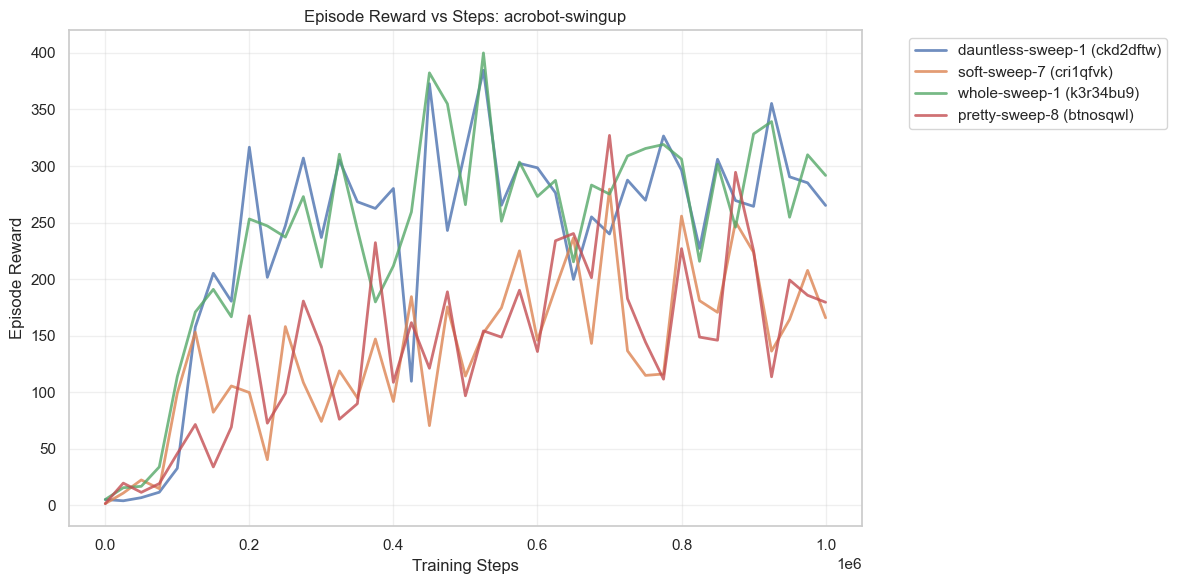

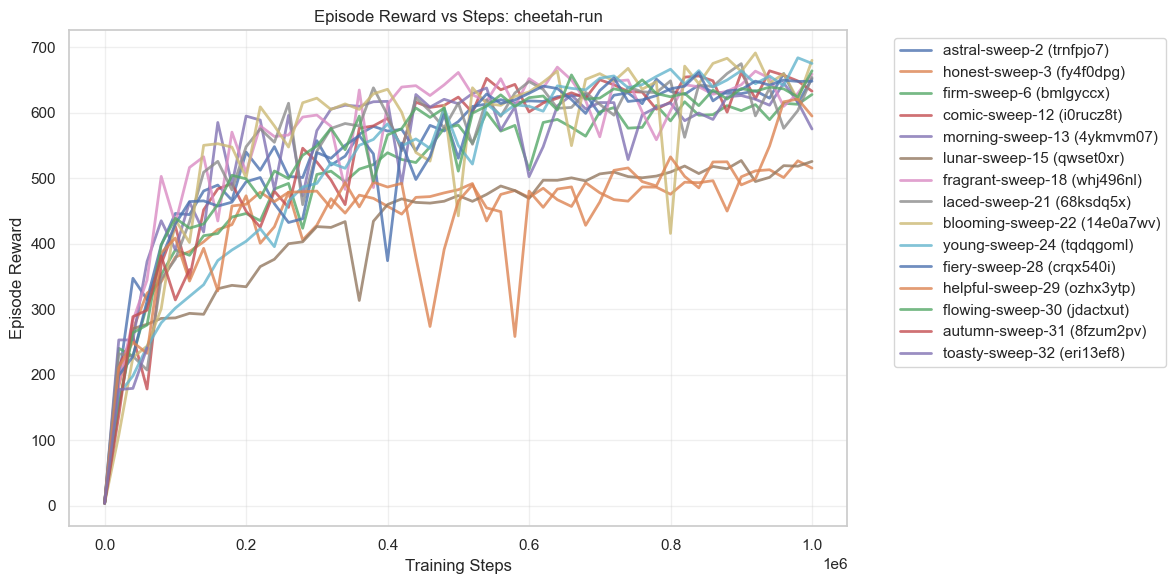

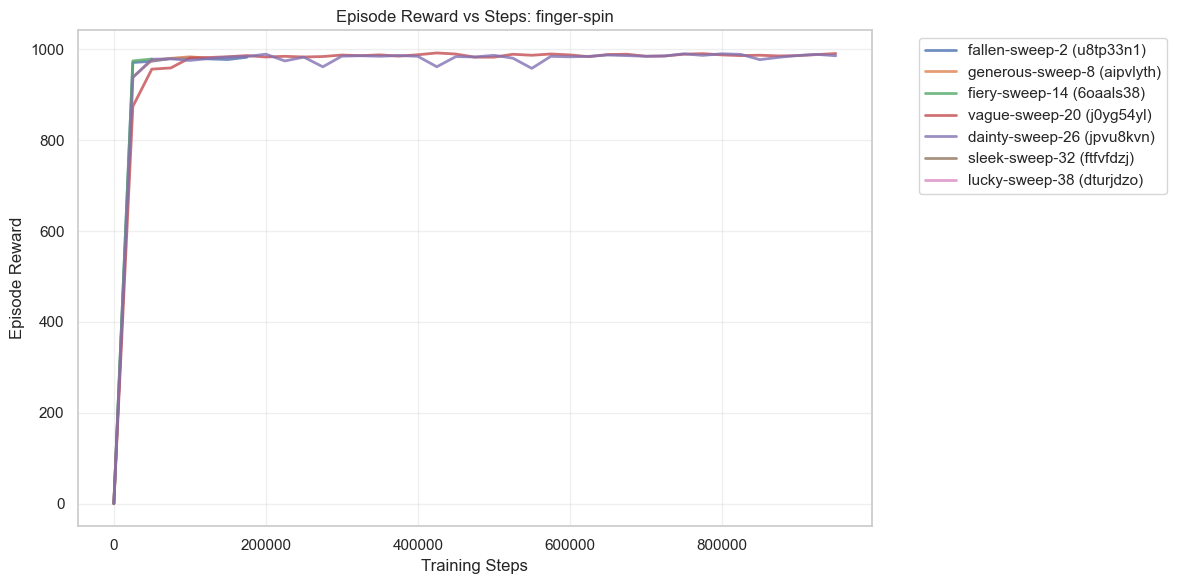

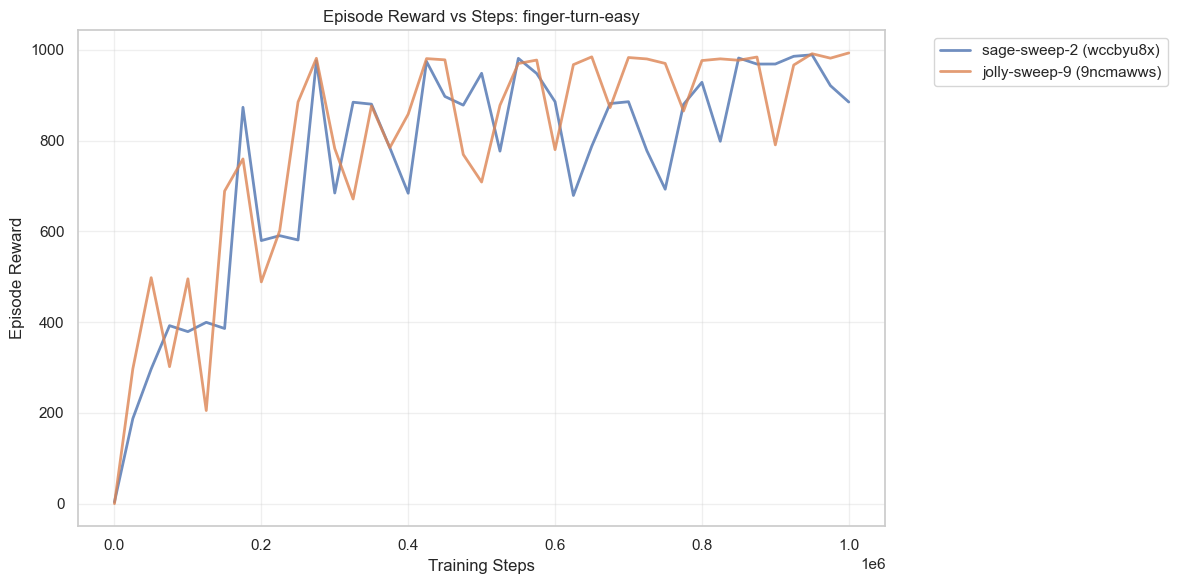

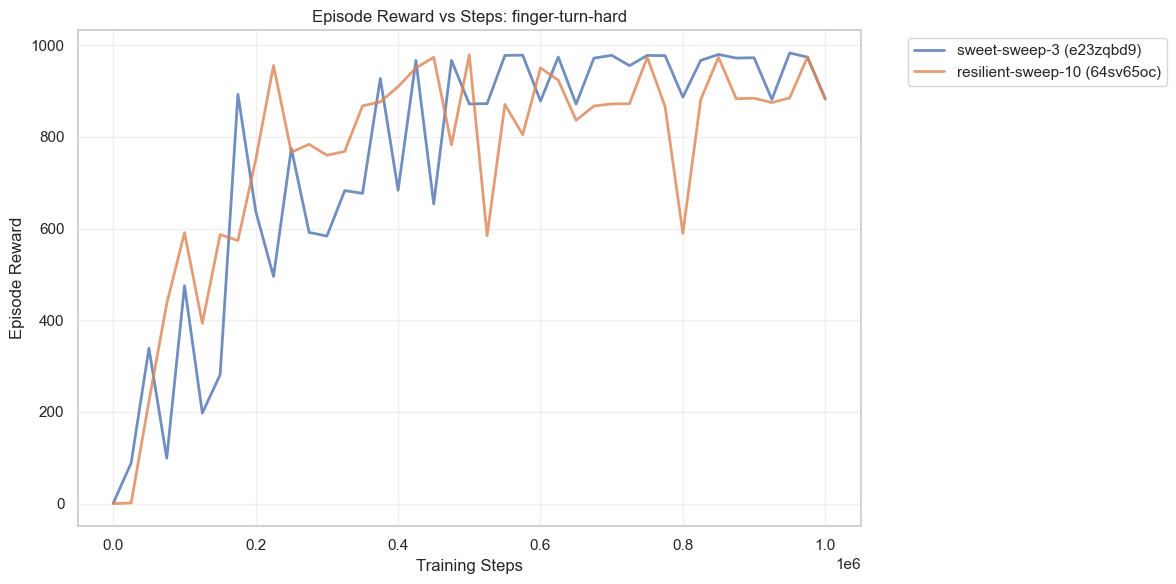

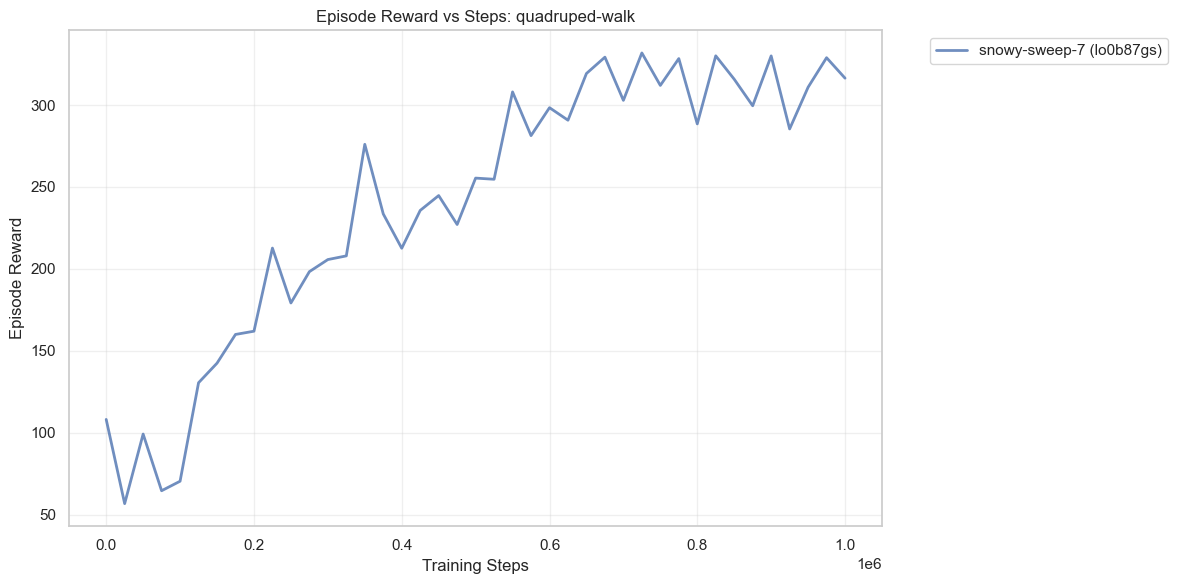

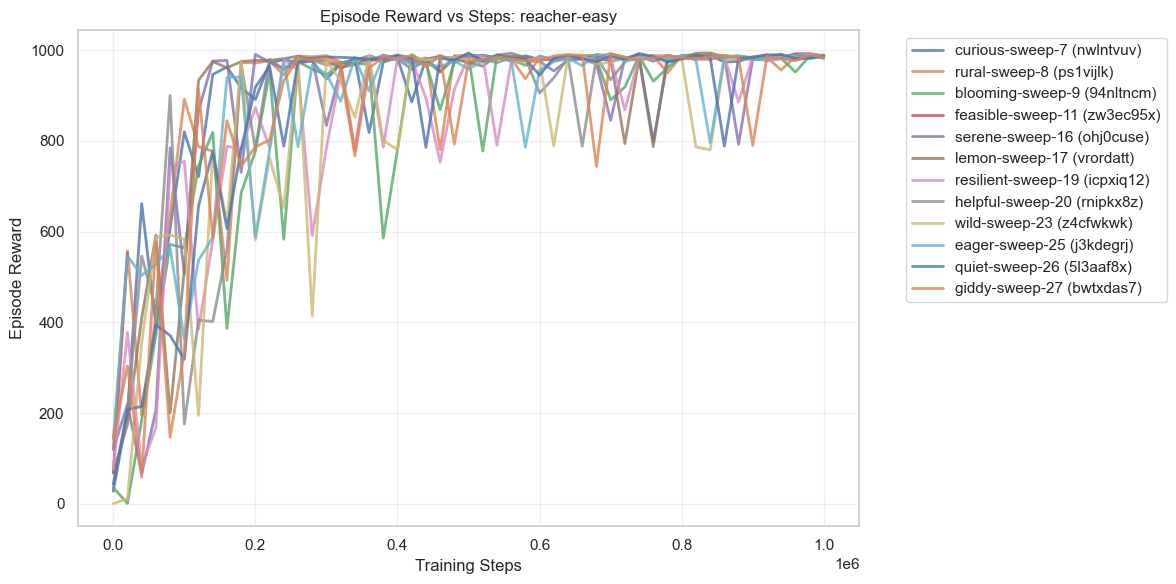

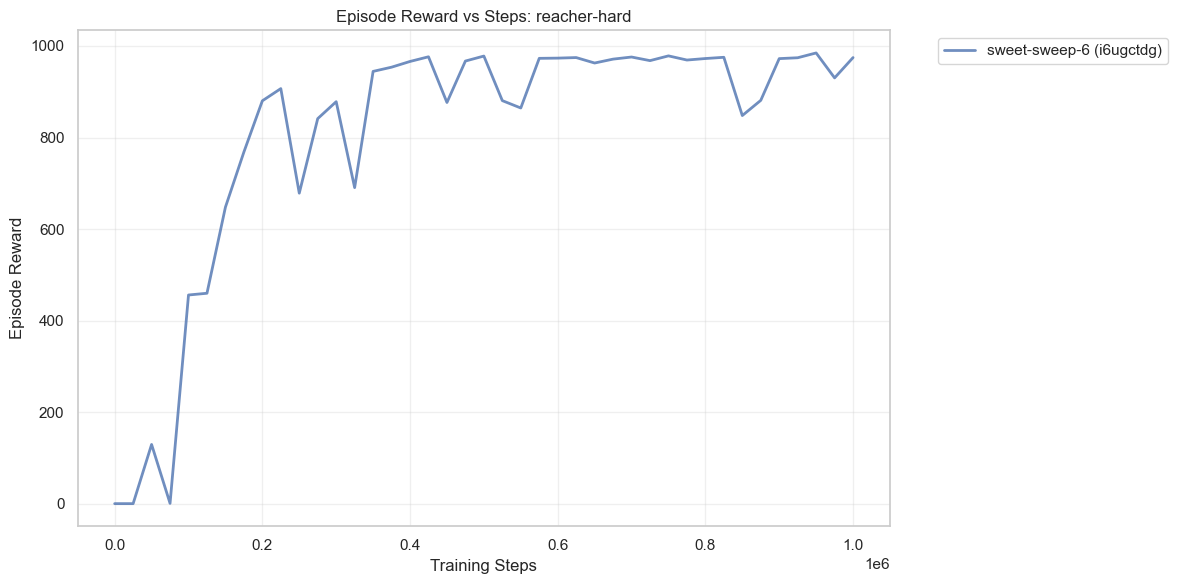

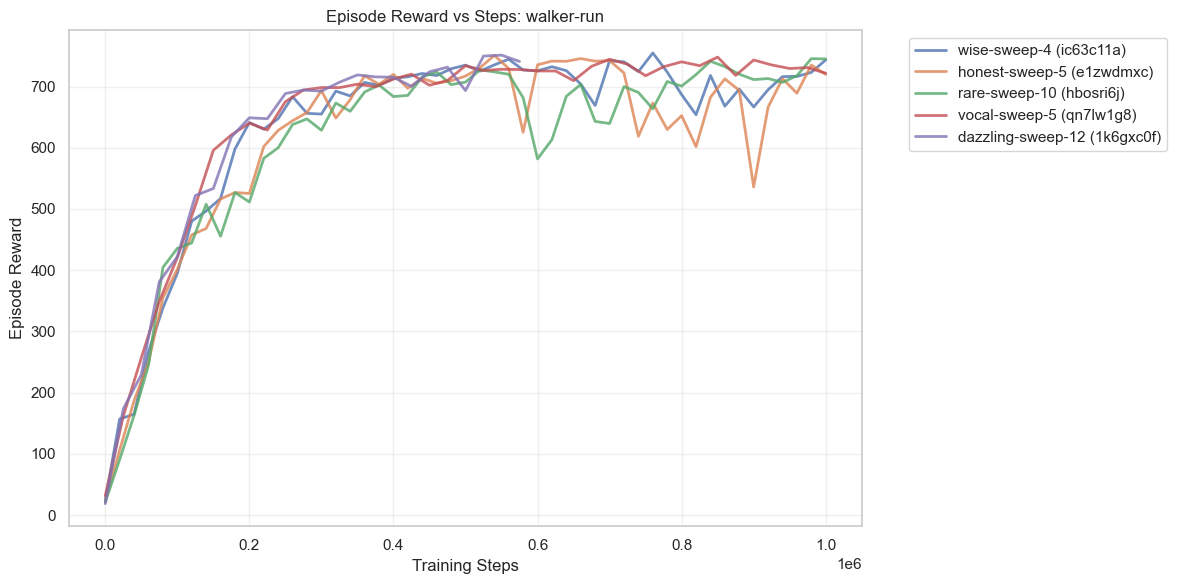

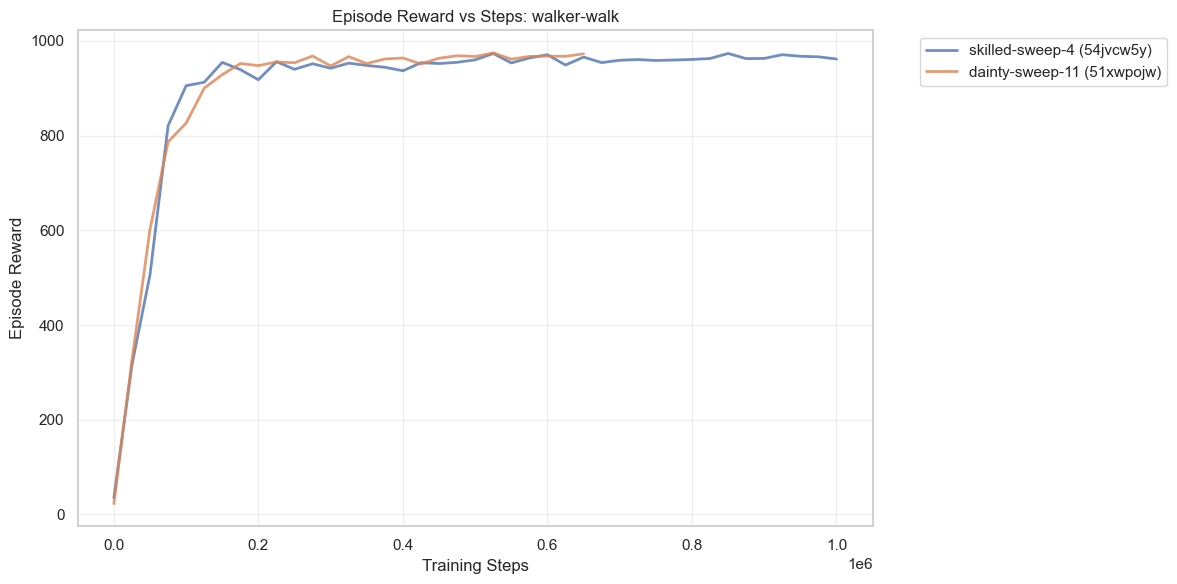

In [53]:
# Plot all W&B runs with episode reward vs steps for each task
tasks = sorted(wandb_df['task'].unique())

for task in tasks:
    plt.figure(figsize=(12, 6))
    
    # Filter data for this task
    task_data = wandb_df[wandb_df['task'] == task]
    
    # Plot each run separately
    for run_id in task_data['run_id'].unique():
        run_data = task_data[task_data['run_id'] == run_id]
        run_name = run_data['run_name'].iloc[0]
        
        plt.plot(run_data['step'], run_data['reward'], 
                label=f'{run_name} ({run_id[:8]})', 
                alpha=0.8, linewidth=2)
    
    plt.title(f'Episode Reward vs Steps: {task}')
    plt.xlabel('Training Steps')
    plt.ylabel('Episode Reward')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Save plot
    plot_file = FIGURES_DIR / "OURS" / f'{task}_wandb_runs.png'
    plt.savefig(plot_file, dpi=120, bbox_inches='tight')
    # plt.show()
    
    print(f'Saved plot: {plot_file}')
    print(f'Number of runs for {task}: {len(task_data["run_id"].unique())}')
    print()

Creating overlay plots for CSV baselines vs W&B runs...
Tasks in CSV data: ['acrobot-swingup', 'cartpole-swingup-sparse', 'cheetah-run', 'finger-spin', 'finger-turn-easy', 'finger-turn-hard', 'quadruped-run', 'quadruped-walk', 'reacher-easy', 'reacher-hard', 'walker-run', 'walker-walk']
Tasks in W&B data: ['acrobot-swingup', 'cheetah-run', 'finger-spin', 'finger-turn-easy', 'finger-turn-hard', 'quadruped-walk', 'reacher-easy', 'reacher-hard', 'walker-run', 'walker-walk']
Common tasks for overlay: ['acrobot-swingup', 'cheetah-run', 'finger-spin', 'finger-turn-easy', 'finger-turn-hard', 'quadruped-walk', 'reacher-easy', 'reacher-hard', 'walker-run', 'walker-walk']


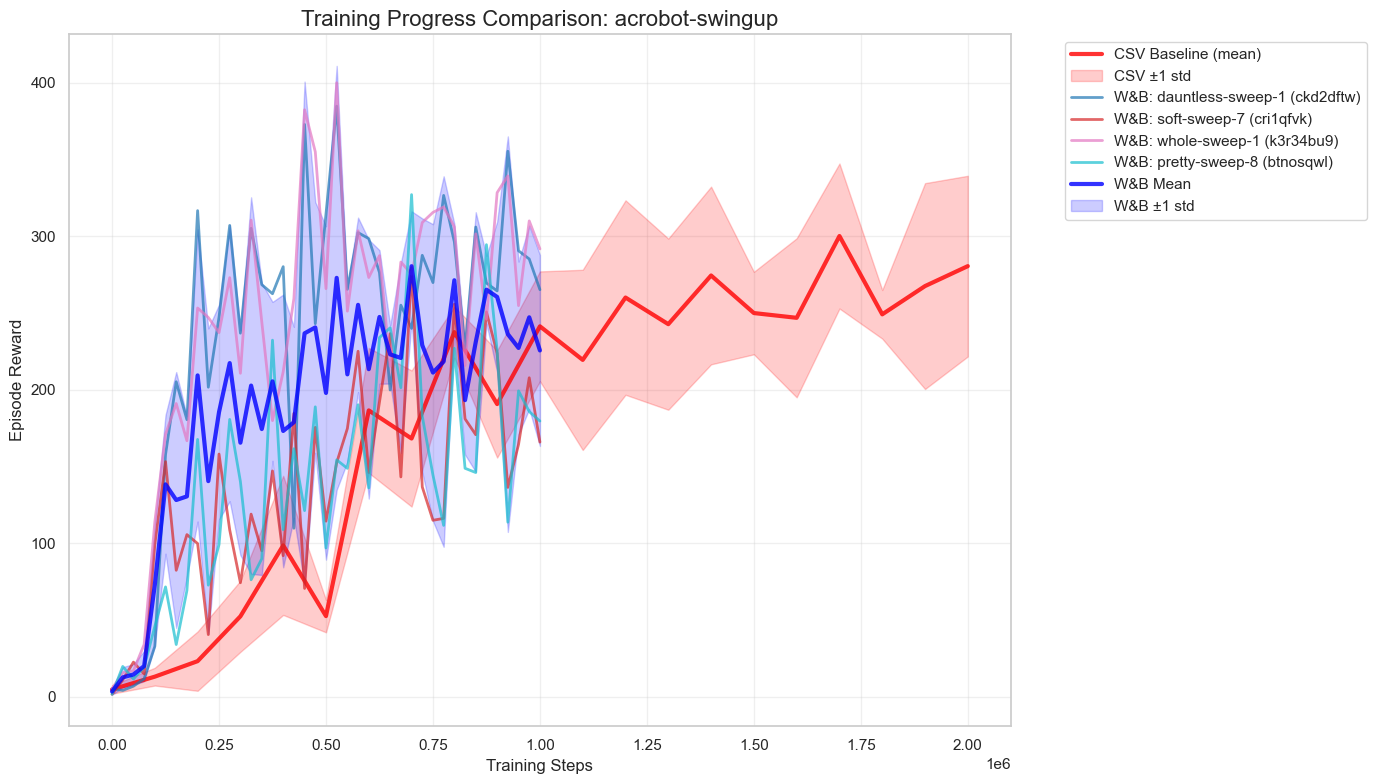

Saved overlay plot: C:\Users\thoma\OneDrive - Delft University of Technology\Documenten\Projects\Auxilary Signals World Models\tdmpc2\notebooks\figures\overlays\acrobot-swingup_csv_vs_wandb_overlay.png
acrobot-swingup - CSV final: 280.5, W&B final: 225.6±53.9



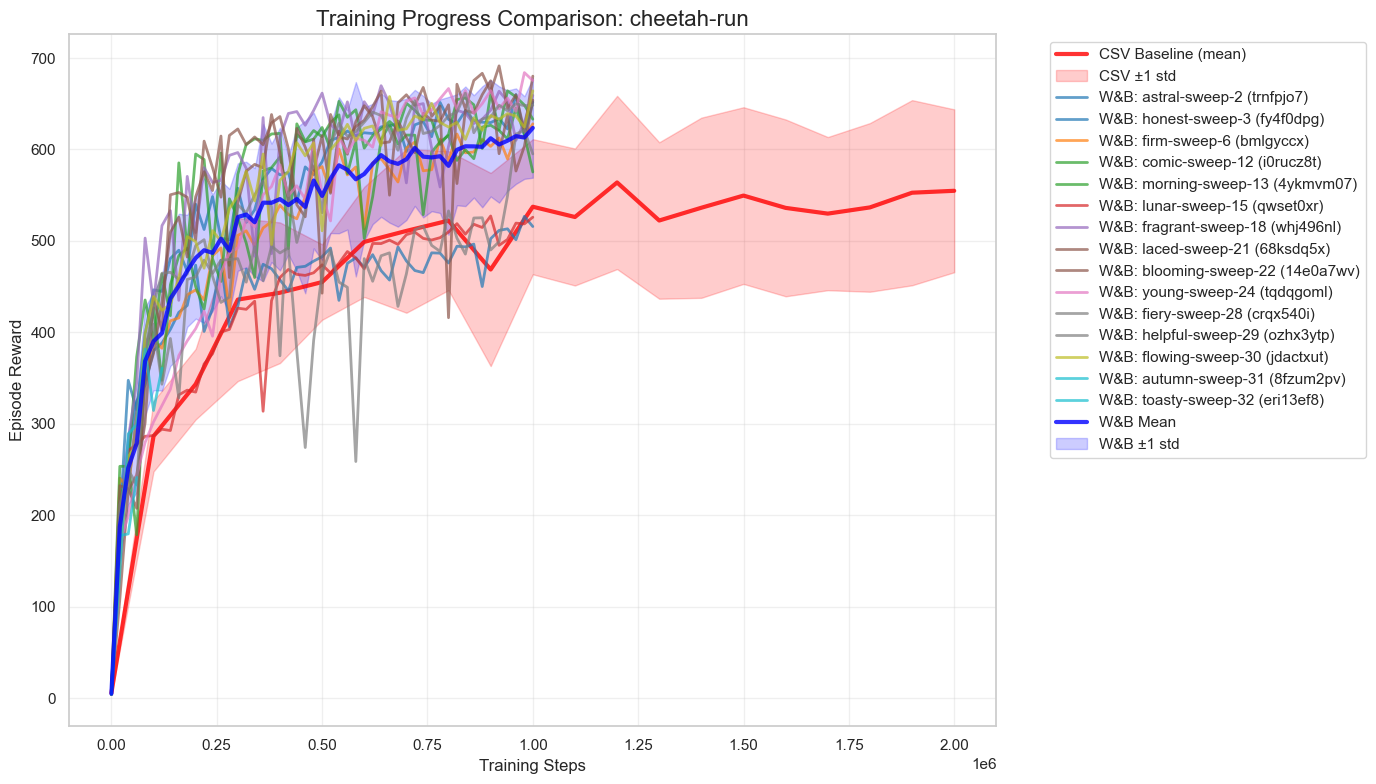

Saved overlay plot: C:\Users\thoma\OneDrive - Delft University of Technology\Documenten\Projects\Auxilary Signals World Models\tdmpc2\notebooks\figures\overlays\cheetah-run_csv_vs_wandb_overlay.png
cheetah-run - CSV final: 554.8, W&B final: 580.5±121.9



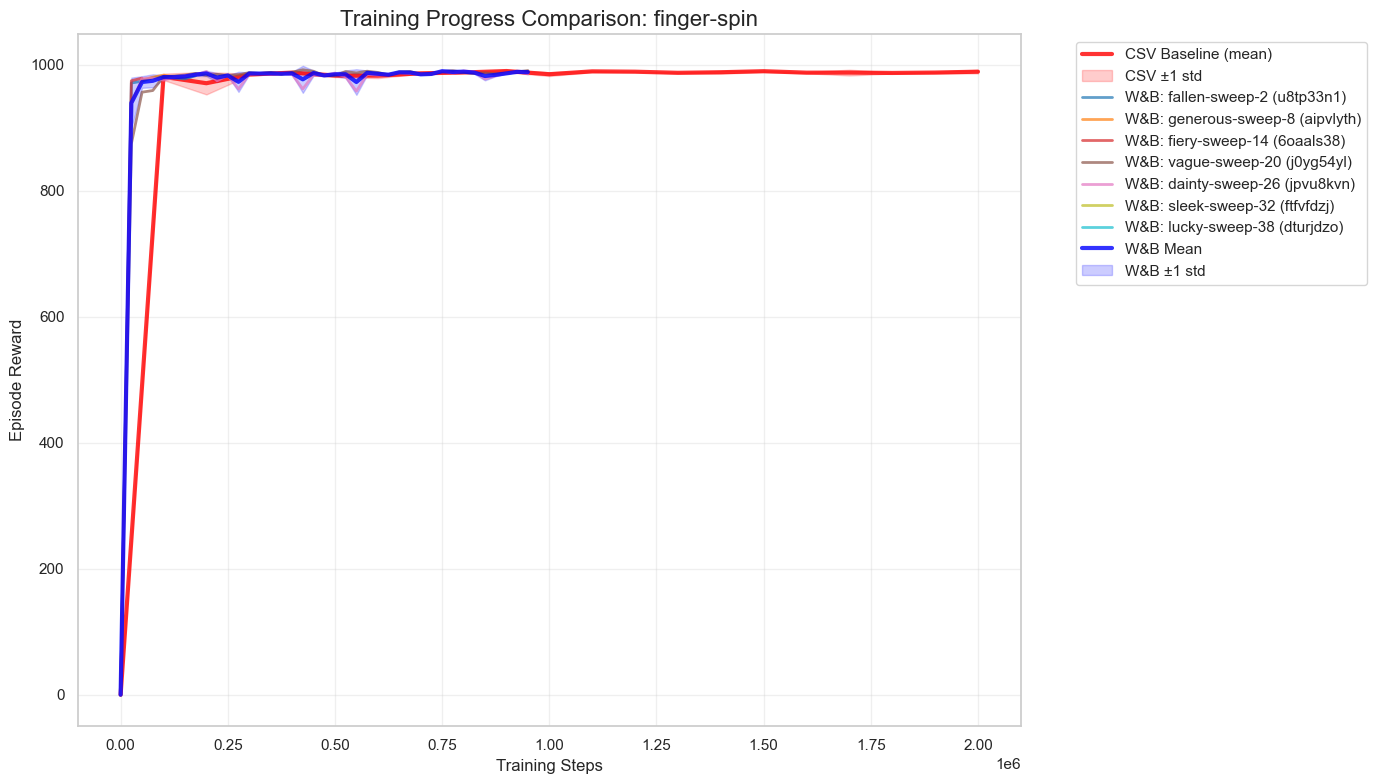

Saved overlay plot: C:\Users\thoma\OneDrive - Delft University of Technology\Documenten\Projects\Auxilary Signals World Models\tdmpc2\notebooks\figures\overlays\finger-spin_csv_vs_wandb_overlay.png
finger-spin - CSV final: 988.9, W&B final: 702.6±444.4



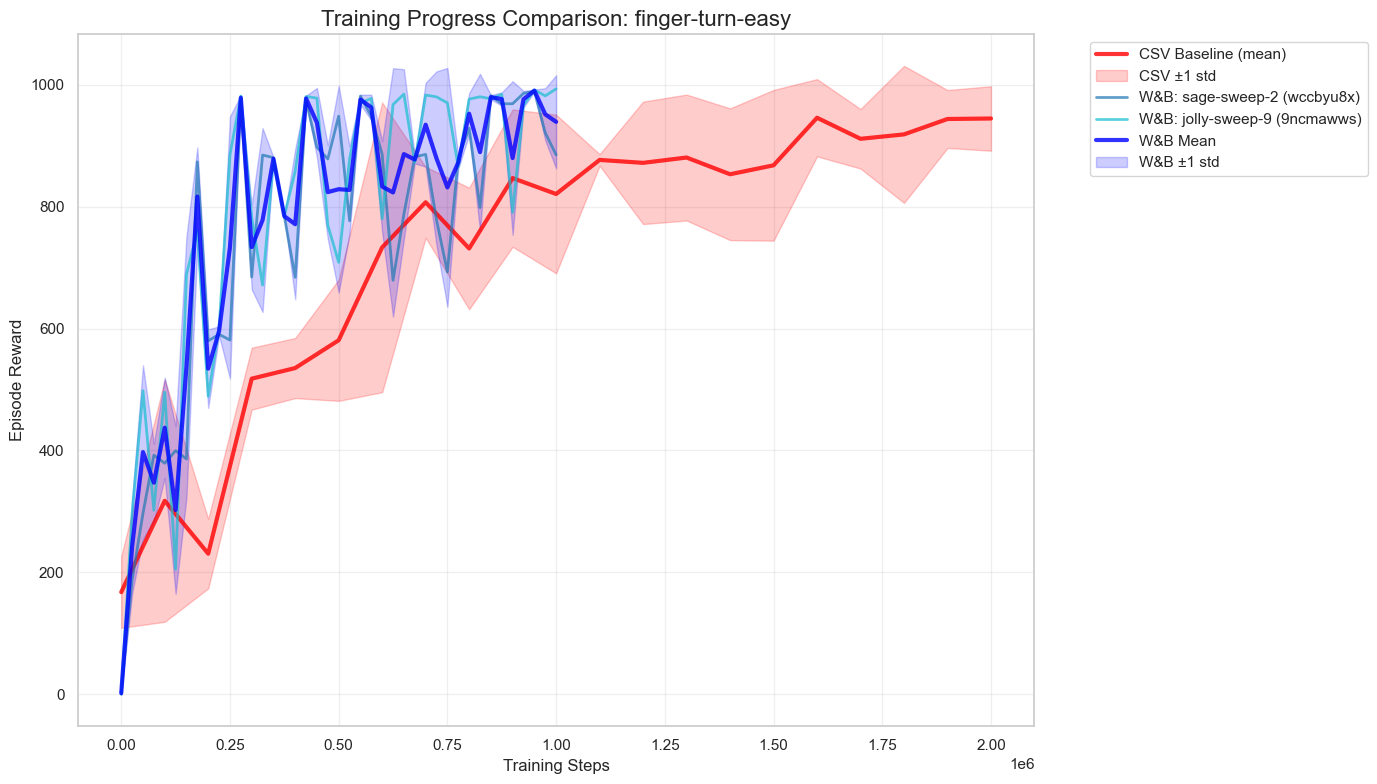

Saved overlay plot: C:\Users\thoma\OneDrive - Delft University of Technology\Documenten\Projects\Auxilary Signals World Models\tdmpc2\notebooks\figures\overlays\finger-turn-easy_csv_vs_wandb_overlay.png
finger-turn-easy - CSV final: 944.7, W&B final: 939.2±54.1



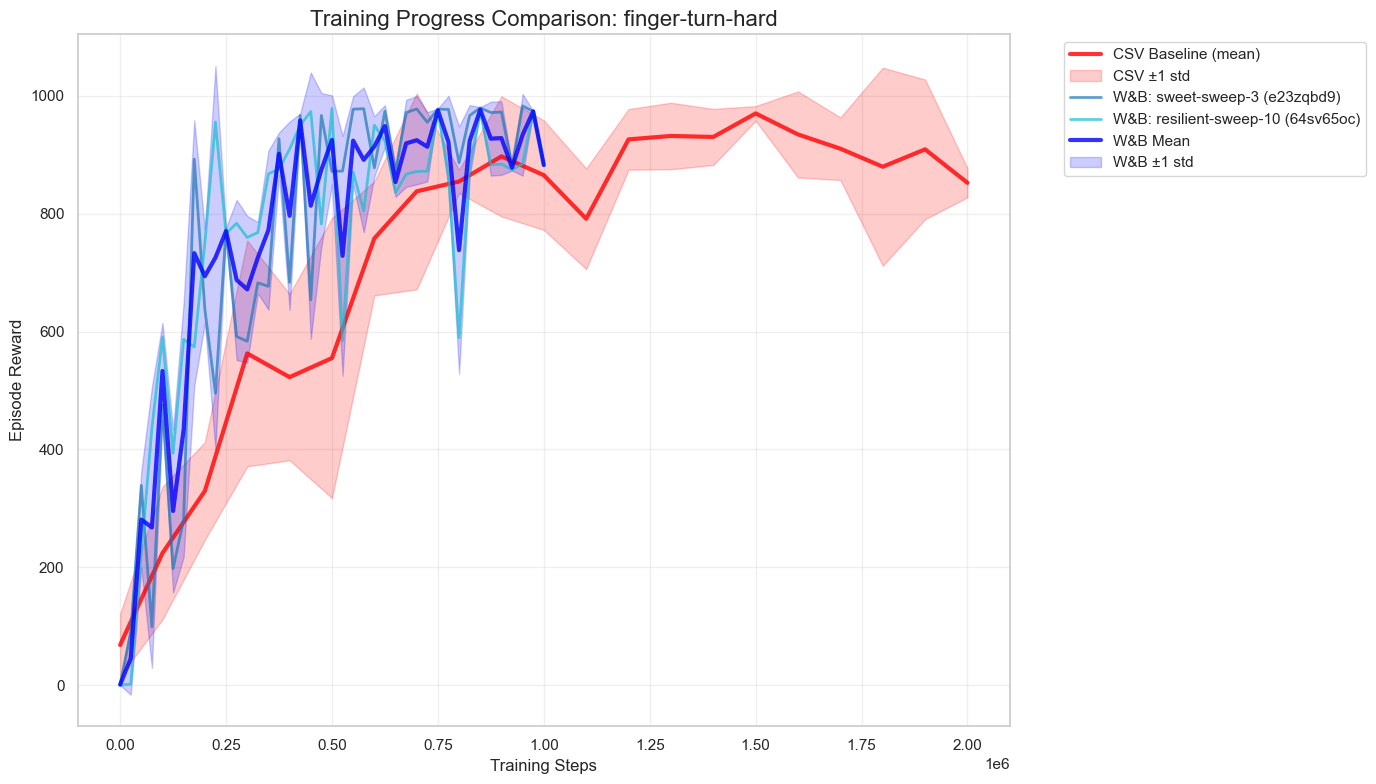

Saved overlay plot: C:\Users\thoma\OneDrive - Delft University of Technology\Documenten\Projects\Auxilary Signals World Models\tdmpc2\notebooks\figures\overlays\finger-turn-hard_csv_vs_wandb_overlay.png
finger-turn-hard - CSV final: 852.6, W&B final: 882.8±0.7



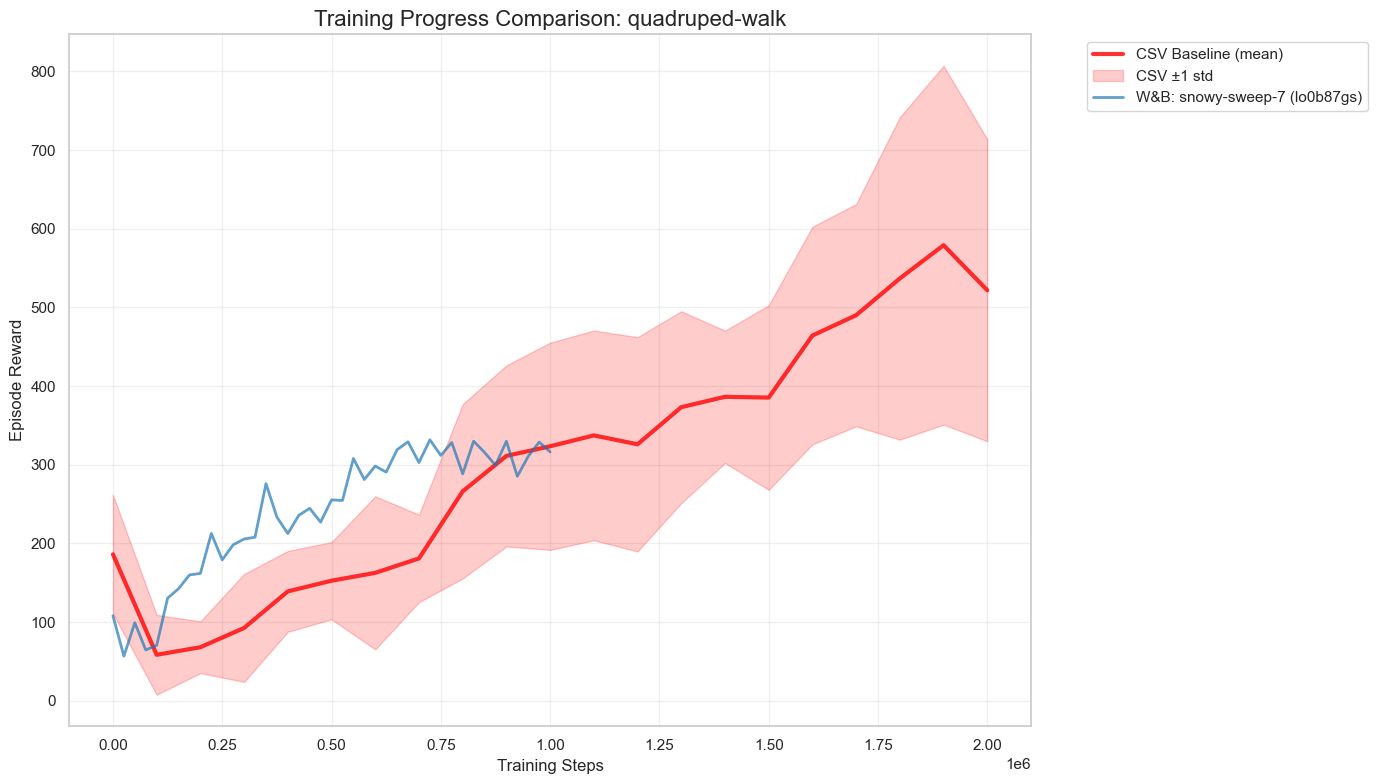

Saved overlay plot: C:\Users\thoma\OneDrive - Delft University of Technology\Documenten\Projects\Auxilary Signals World Models\tdmpc2\notebooks\figures\overlays\quadruped-walk_csv_vs_wandb_overlay.png
quadruped-walk - CSV final: 521.8, W&B final: 316.4±0.0



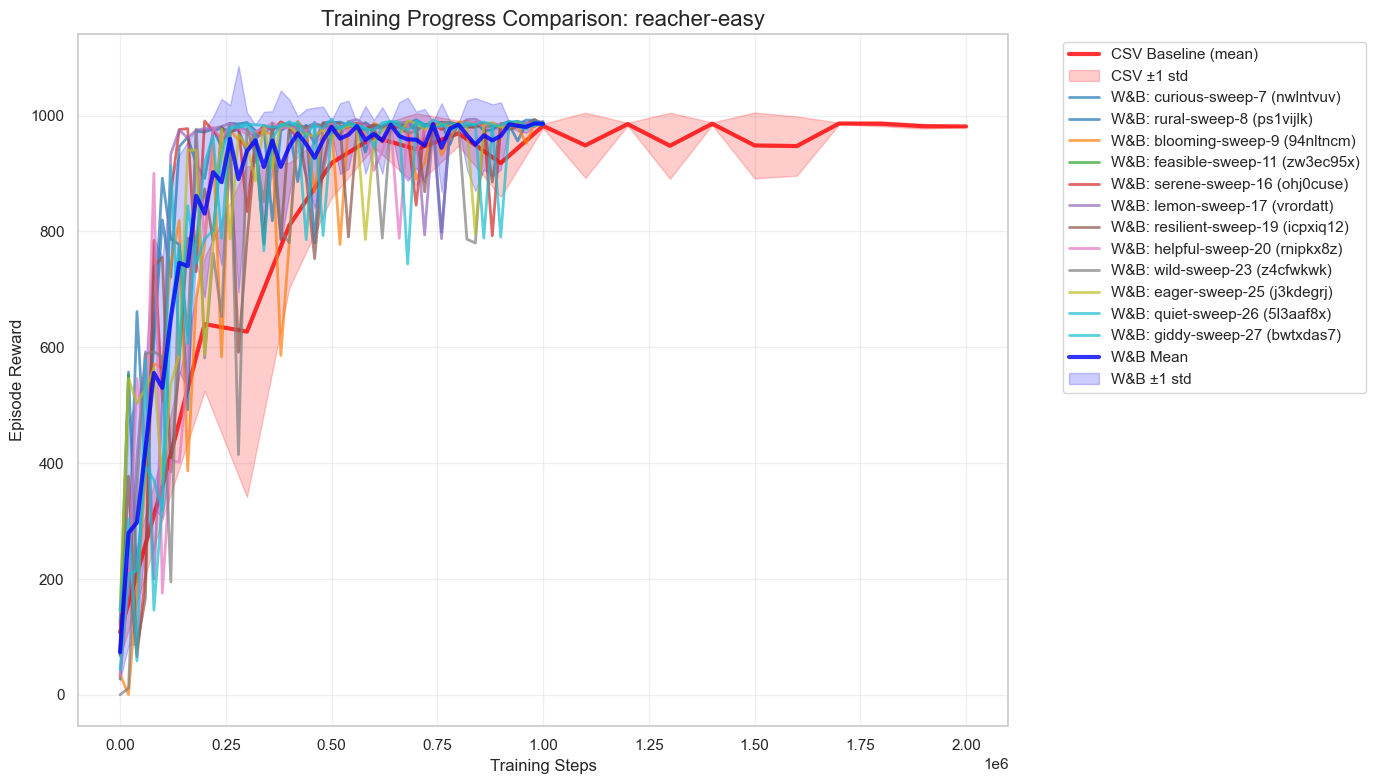

Saved overlay plot: C:\Users\thoma\OneDrive - Delft University of Technology\Documenten\Projects\Auxilary Signals World Models\tdmpc2\notebooks\figures\overlays\reacher-easy_csv_vs_wandb_overlay.png
reacher-easy - CSV final: 981.2, W&B final: 949.6±119.9



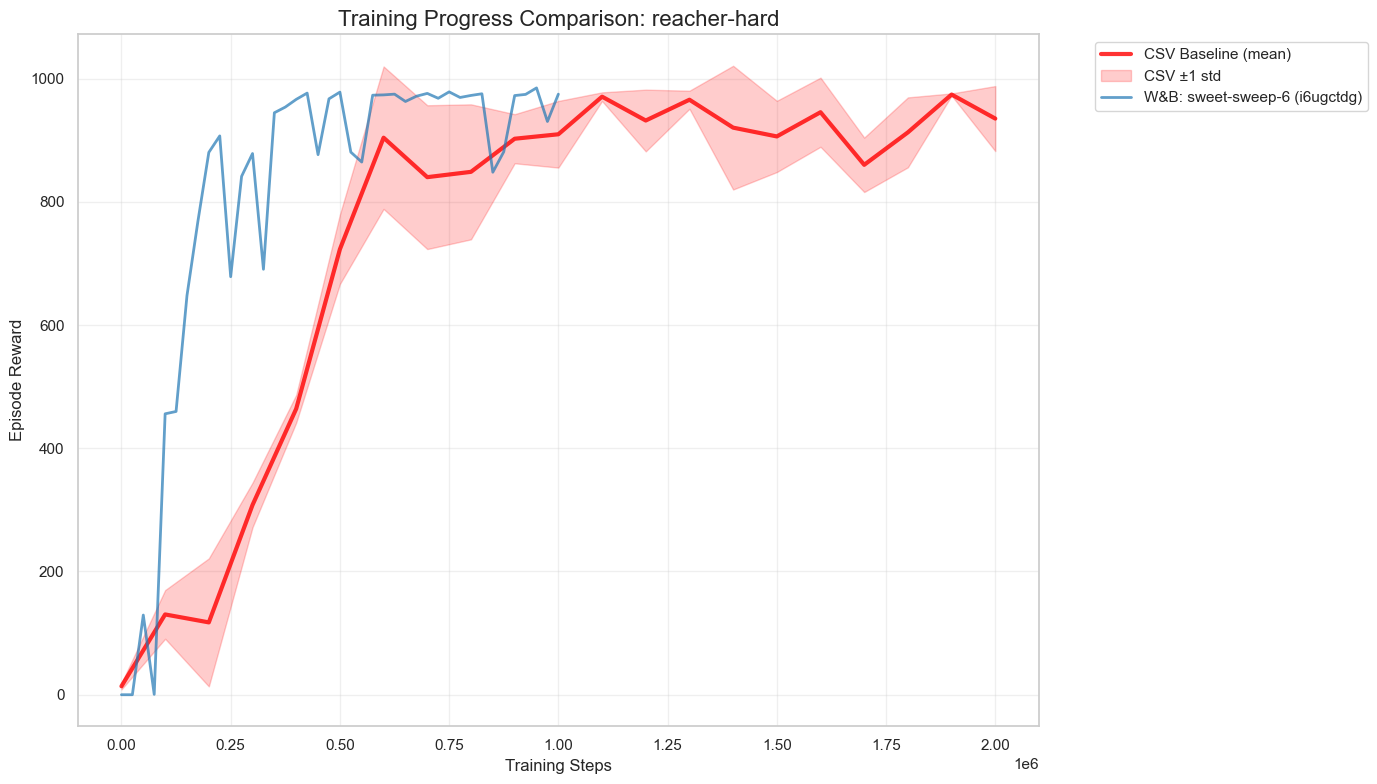

Saved overlay plot: C:\Users\thoma\OneDrive - Delft University of Technology\Documenten\Projects\Auxilary Signals World Models\tdmpc2\notebooks\figures\overlays\reacher-hard_csv_vs_wandb_overlay.png
reacher-hard - CSV final: 935.0, W&B final: 974.7±0.0



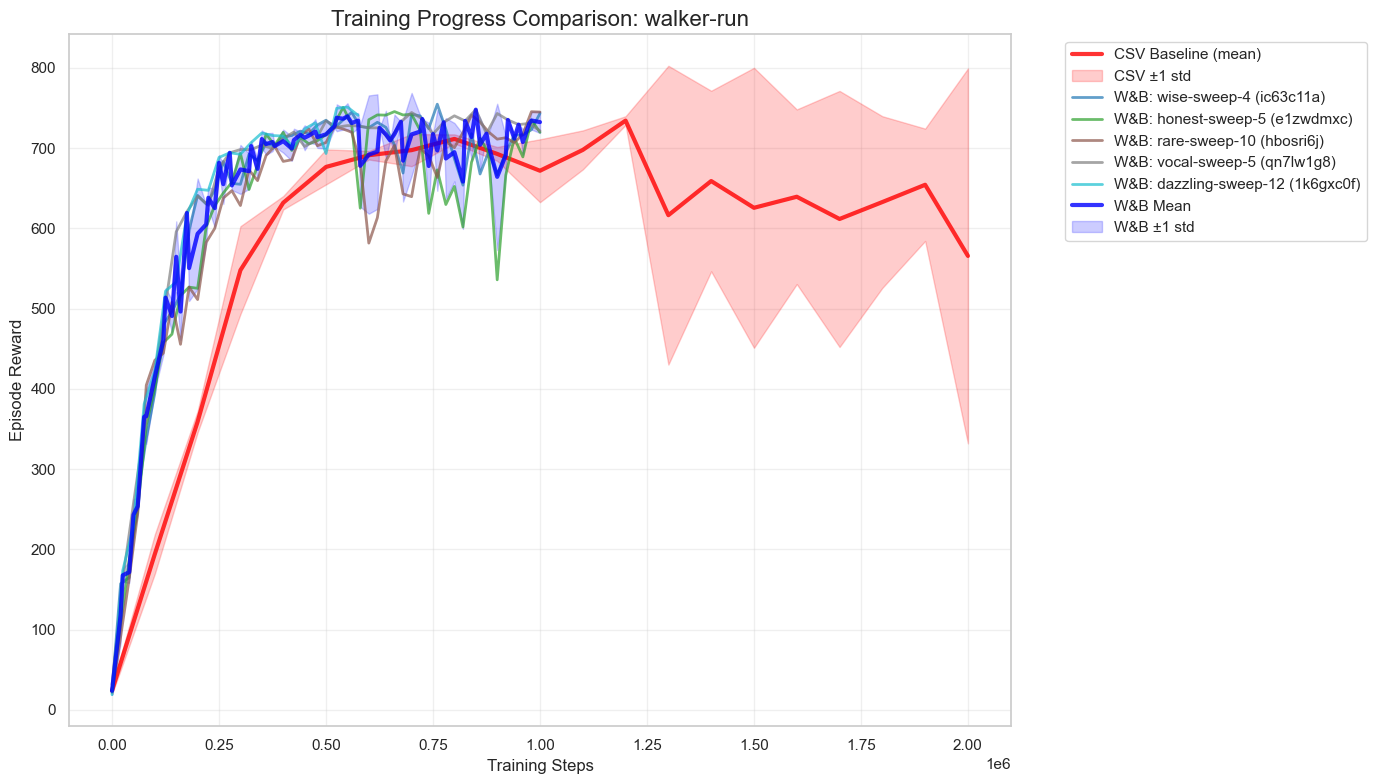

Saved overlay plot: C:\Users\thoma\OneDrive - Delft University of Technology\Documenten\Projects\Auxilary Signals World Models\tdmpc2\notebooks\figures\overlays\walker-run_csv_vs_wandb_overlay.png
walker-run - CSV final: 565.7, W&B final: 734.2±11.1



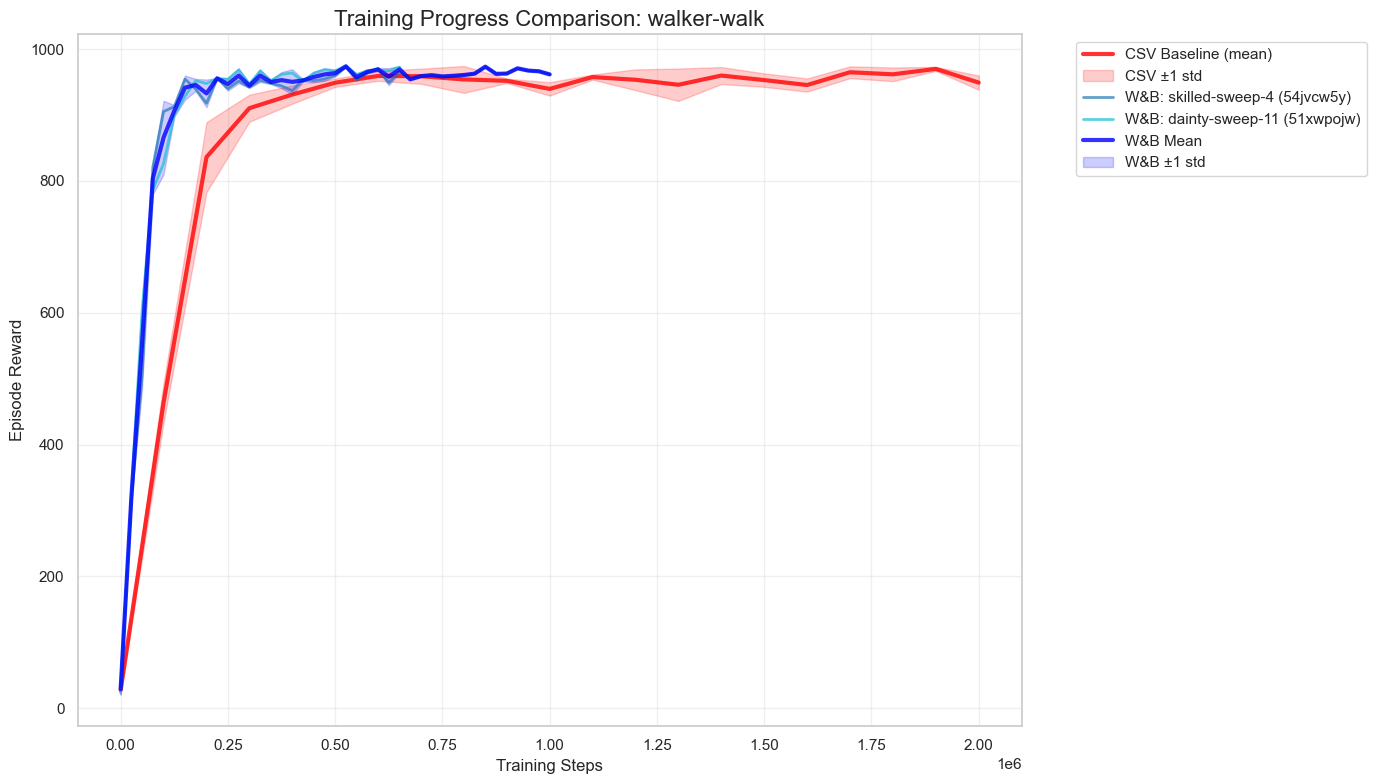

Saved overlay plot: C:\Users\thoma\OneDrive - Delft University of Technology\Documenten\Projects\Auxilary Signals World Models\tdmpc2\notebooks\figures\overlays\walker-walk_csv_vs_wandb_overlay.png
walker-walk - CSV final: 949.2, W&B final: 967.2±5.5

Overlay analysis complete!


In [54]:
# Create overlay plots comparing CSV baseline data with W&B runs for each task
print("Creating overlay plots for CSV baselines vs W&B runs...")

# Get tasks that exist in both datasets
csv_tasks = set(step_stats['task'].unique())
wandb_tasks = set(wandb_df['task'].unique())
common_tasks = csv_tasks.intersection(wandb_tasks)

print(f"Tasks in CSV data: {sorted(csv_tasks)}")
print(f"Tasks in W&B data: {sorted(wandb_tasks)}")
print(f"Common tasks for overlay: {sorted(common_tasks)}")

# Create overlay plots for each common task
for task in sorted(common_tasks):
    plt.figure(figsize=(14, 8))
    
    # Plot CSV baseline data (step_stats aggregated)
    csv_task_data = step_stats[step_stats['task'] == task]
    plt.plot(csv_task_data['step'], csv_task_data['mean_reward'], 
             label='CSV Baseline (mean)', linewidth=3, color='red', alpha=0.8)
    
    # Add shaded region for CSV std
    if csv_task_data['std_reward'].notna().any():
        upper = csv_task_data['mean_reward'] + csv_task_data['std_reward'].fillna(0)
        lower = csv_task_data['mean_reward'] - csv_task_data['std_reward'].fillna(0)
        plt.fill_between(csv_task_data['step'], lower, upper, 
                        alpha=0.2, color='red', label='CSV ±1 std')
    
    # Plot individual W&B runs
    wandb_task_data = wandb_df[wandb_df['task'] == task]
    run_colors = plt.cm.tab10(np.linspace(0, 1, len(wandb_task_data['run_id'].unique())))
    
    for i, run_id in enumerate(wandb_task_data['run_id'].unique()):
        run_data = wandb_task_data[wandb_task_data['run_id'] == run_id]
        run_name = run_data['run_name'].iloc[0]
        
        plt.plot(run_data['step'], run_data['reward'], 
                label=f'W&B: {run_name} ({run_id[:8]})', 
                alpha=0.7, linewidth=2, color=run_colors[i])
    
        # Calculate and plot W&B mean and std across runs
    if len(wandb_task_data['run_id'].unique()) > 1:
        # Group by step and calculate mean/std across runs
        wandb_stats = (wandb_task_data
                      .groupby('step')
                      .agg(mean_reward=('reward', 'mean'),
                           std_reward=('reward', 'std'))
                      .reset_index())
        
        # Plot W&B mean with std shading
        plt.plot(wandb_stats['step'], wandb_stats['mean_reward'], 
                label='W&B Mean', linewidth=3, color='blue', alpha=0.8)
        
        if wandb_stats['std_reward'].notna().any():
            upper = wandb_stats['mean_reward'] + wandb_stats['std_reward'].fillna(0)
            lower = wandb_stats['mean_reward'] - wandb_stats['std_reward'].fillna(0)
            plt.fill_between(wandb_stats['step'], lower, upper, 
                            alpha=0.2, color='blue', label='W&B ±1 std')
             
             
    plt.title(f'Training Progress Comparison: {task}', fontsize=16)
    plt.xlabel('Training Steps', fontsize=12)
    plt.ylabel('Episode Reward', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Save overlay plot
    overlay_dir = FIGURES_DIR / "overlays"
    overlay_dir.mkdir(exist_ok=True)
    overlay_file = overlay_dir / f'{task}_csv_vs_wandb_overlay.png'
    plt.savefig(overlay_file, dpi=120, bbox_inches='tight')
    plt.show()
    
    print(f'Saved overlay plot: {overlay_file}')
    
    # Print comparison statistics
    csv_final = csv_task_data.iloc[-1]['mean_reward']
    wandb_final_rewards = []
    for run_id in wandb_task_data['run_id'].unique():
        run_data = wandb_task_data[wandb_task_data['run_id'] == run_id]
        if len(run_data) > 0:
            wandb_final_rewards.append(run_data.iloc[-1]['reward'])
    

    
    if wandb_final_rewards:
        wandb_final_mean = np.mean(wandb_final_rewards)
        wandb_final_std = np.std(wandb_final_rewards)
        print(f'{task} - CSV final: {csv_final:.1f}, W&B final: {wandb_final_mean:.1f}±{wandb_final_std:.1f}')
    print()

print("Overlay analysis complete!")